In [1]:
import keras
from keras import backend as K
from keras.layers import Dense, Input, merge
from keras.engine.topology import Layer
import numpy as np
from tensorflow.contrib.distributions import Categorical, Mixture, MultivariateNormalDiag
import tensorflow as tf
import math
import h5py
import random
import time
import pandas as pd
from context import * # imports robojam
# import robojam # alternatively do this.
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook


input_colour = 'darkblue'
gen_colour = 'firebrick'
plt.style.use('seaborn-talk')

Using TensorFlow backend.


In [50]:
def perf_df_to_array(perf_df):
    """Converts a dataframe of a performance into array a,b,dt format."""
    perf_df['dt'] = perf_df.time.diff()
    perf_df.dt = perf_df.dt.fillna(0.0)
    # Clean performance data
    # Tiny Performance bounds defined to be in [[0,1],[0,1]], edit to fix this.
    perf_df.set_value(perf_df[perf_df.dt > 5].index, 'dt', 5.0)
    perf_df.set_value(perf_df[perf_df.dt < 0].index, 'dt', 0.0)
    perf_df.set_value(perf_df[perf_df.x > 1].index, 'x', 1.0)
    perf_df.set_value(perf_df[perf_df.x < 0].index, 'x', 0.0)
    perf_df.set_value(perf_df[perf_df.y > 1].index, 'y', 1.0)
    perf_df.set_value(perf_df[perf_df.y < 0].index, 'y', 0.0)
    return np.array(perf_df[['x', 'y', 'dt']])


def perf_array_to_df(perf_array):
    """Converts an array of a performance (a,b,dt format) into a dataframe."""
    perf_array = perf_array.T
    perf_df = pd.DataFrame({'x': perf_array[0], 'y': perf_array[1], 'dt': perf_array[2]})
    perf_df['time'] = perf_df.dt.cumsum()
    perf_df['z'] = 38.0
    # As a rule of thumb, could classify taps with dt>0.1 as taps, dt<0.1 as moving touches.
    perf_df['moving'] = 1
    perf_df.set_value(perf_df[perf_df.dt > 0.1].index, 'moving', 0)
    perf_df = perf_df.set_index(['time'])
    return perf_df[['x', 'y', 'z', 'moving']]


def random_touch():
    """Generate a random tiny performance touch."""
    return np.array([np.random.rand(), np.random.rand(), 0.01])


def constrain_touch(touch):
    """Constrain touch values from the MDRNN"""
    touch[0] = min(max(touch[0], 0.0), 1.0)  # x in [0,1]
    touch[1] = min(max(touch[1], 0.0), 1.0)  # y in [0,1]
    touch[2] = max(touch[2], 0.001)  # dt # define minimum time step
    return touch

def generate_random_tiny_performance(model, first_touch, time_limit=5.0, steps_limit=1000, temp=1.0):
    """Generates a tiny performance up to 5 seconds in length."""
    time = 0
    steps = 0
    previous_touch = first_touch
    performance = [previous_touch.reshape((3,))]
    while (steps < steps_limit and time < time_limit):
        previous_touch = model.predict(previous_touch.reshape(1,1,3))
        output_touch = previous_touch.reshape(3,)
        output_touch = constrain_touch(output_touch)
        performance.append(output_touch.reshape((3,)))
        steps += 1
        time += output_touch[2]
    return np.array(performance)


def condition_and_generate(model, perf, n_mixtures, time_limit=5.0, steps_limit=1000, temp=1.0):
    """Conditions the network on an existing tiny performance, then generates a new one."""
    time = 0
    steps = 0
    # condition
    for touch in perf:
        params = model.predict(touch.reshape(1,1,3))
        previous_touch = sample_from_output(params[0], n_mixtures, 3, temp=temp)
    output = [previous_touch.reshape((3,))]
    while (steps < steps_limit and time < time_limit):
        params = model.predict(previous_touch.reshape(1,1,3))
        previous_touch = sample_from_output(params[0], n_mixtures, 3, temp=temp)
        output_touch = previous_touch.reshape(3,)
        output_touch = constrain_touch(output_touch)
        output.append(output_touch.reshape((3,)))
        steps += 1
        time += output_touch[2]
    net_output = np.array(output)
    return net_output

def divide_performance_into_swipes(perf_df):
    """Divides a performance into a sequence of swipe dataframes for plotting."""
    touch_starts = perf_df[perf_df.moving == 0].index
    performance_swipes = []
    remainder = perf_df
    for att in touch_starts:
        swipe = remainder.iloc[remainder.index < att]
        performance_swipes.append(swipe)
        remainder = remainder.iloc[remainder.index >= att]
    performance_swipes.append(remainder)
    return performance_swipes

def plot_2D(perf_df, name="foo", saving=False):
    """Plot a 2D representation of a performance 2D"""
    swipes = divide_performance_into_swipes(perf_df)
    plt.figure(figsize=(8, 8))
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    plt.ylim(1.0,0)
    plt.xlim(0,1.0)
    plt.xticks([])
    plt.yticks([])
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def plot_double_2d(perf1, perf2, name="foo", saving=False):
    """Plot two performances in 2D"""
    plt.figure(figsize=(8, 8))
    swipes = divide_performance_into_swipes(perf1)
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=input_colour, linewidth=5.0)
    swipes = divide_performance_into_swipes(perf2)
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    plt.ylim(1.0,0)
    plt.xlim(0,1.0)
    plt.xticks([])
    plt.yticks([])
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

## Mixture Density Layer in Keras

See [https://github.com/cpmpercussion/keras-mdn-layer](https://github.com/cpmpercussion/keras-mdn-layer) for more details.

In [3]:
import keras
from keras import backend as K
from keras.layers import Dense
from keras.engine.topology import Layer
import numpy as np
from tensorflow.contrib.distributions import Categorical, Mixture, MultivariateNormalDiag
import tensorflow as tf


def elu_plus_one_plus_epsilon(x):
    """ELU activation with a very small addition to help prevent NaN in loss."""
    return (K.elu(x) + 1 + 1e-8)


class MDN(Layer):
    """A Mixture Density Network Layer for Keras.
    This layer has a few tricks to avoid NaNs in the loss function when training:
        - Activation for variances is ELU + 1 + 1e-8 (to avoid very small values)
        - Mixture weights (pi) are trained in as logits, not in the softmax space.

    A loss function needs to be constructed with the same output dimension and number of mixtures.
    A sampling function is also provided to sample from distribution parametrised by the MDN outputs.
    """

    def __init__(self, output_dim, num_mix, **kwargs):
        self.output_dim = output_dim
        self.num_mix = num_mix
        with tf.name_scope('MDN'):
            self.mdn_mus = Dense(self.num_mix * self.output_dim, name='mdn_mus')  # mix*output vals, no activation
            self.mdn_sigmas = Dense(self.num_mix * self.output_dim, activation=elu_plus_one_plus_epsilon, name='mdn_sigmas')  # mix*output vals exp activation
            self.mdn_pi = Dense(self.num_mix, name='mdn_pi')  # mix vals, logits
        super(MDN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        self.trainable_weights = self.mdn_mus.trainable_weights + self.mdn_sigmas.trainable_weights + self.mdn_pi.trainable_weights
        self.non_trainable_weights = self.mdn_mus.non_trainable_weights + self.mdn_sigmas.non_trainable_weights + self.mdn_pi.non_trainable_weights
        super(MDN, self).build(input_shape)

    def call(self, x, mask=None):
        with tf.name_scope('MDN'):
            mdn_out = keras.layers.concatenate([self.mdn_mus(x),
                                                self.mdn_sigmas(x),
                                                self.mdn_pi(x)],
                                               name='mdn_outputs')
        return mdn_out

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


def get_mixture_loss_func(output_dim, num_mixes):
    """Construct a loss functions for the MDN layer parametrised by number of mixtures."""
    # Construct a loss function with the right number of mixtures and outputs
    def loss_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss

    # Actually return the loss_func
    with tf.name_scope('MDN'):
        return loss_func


def get_mixture_sampling_fun(output_dim, num_mixes):
    """Construct a sampling function for the MDN layer parametrised by mixtures and output dimension."""
    # Construct a loss function with the right number of mixtures and outputs
    def sampling_func(y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        # Todo: temperature adjustment for sampling function.
        return samp

    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return sampling_func


def get_mixture_mse_accuracy(output_dim, num_mixes):
    """Construct an MSE accuracy function for the MDN layer
    that takes one sample and compares to the true value."""
    # Construct a loss function with the right number of mixtures and outputs
    def mse_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        mse = tf.reduce_mean(tf.square(samp - y_true), axis=-1)
        # Todo: temperature adjustment for sampling functon.
        return mse

    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return mse_func


# # Sample from Categorical distribution
# def sample_mixture(mus, sigs, pis):
#     """Sample from a mixture of 1D normal distributions parameterised by mus, sigma, and pi."""
#     m = np.random.choice(range(len(pis)), p=pis)
#     return(np.random.normal(mus[m],sigs[m],1))

def split_mixture_params(params, mixtures, dim):
    """Splits up an array of mixture parameters into mus, sigmas, and pis
    depending on the number of mixtures and output dimension."""
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = params[2*mixtures*dim:]
    return mus, sigs, pis


def adjust_temp(pi_pdf, temp):
    """ Adjusts temperature of a PDF describing a categorical model """
    pi_pdf = np.log(pi_pdf) / temp
    pi_pdf -= pi_pdf.max()
    pi_pdf = np.exp(pi_pdf)
    pi_pdf /= pi_pdf.sum()
    return pi_pdf


def get_pi_idx(x, pdf, temp=1.0, greedy=False):
    """Samples from a categorical model PDF, optionally greedily."""
    if greedy:
        return np.argmax(pdf)
    pdf = adjust_temp(np.copy(pdf), temp)
    accumulate = 0
    for i in range(0, pdf.size):
        accumulate += pdf[i]
        if accumulate >= x:
            return i
    tf.logging.info('Error sampling mixture model.')
    return -1


def sample_from_categorical(dist, temp):
    """Sample from a categorical model with temperature adjustment."""
    r = np.random.rand(1)
    return get_pi_idx(r,dist,temp)


def softmax(w, t=1.0):
    """Softmax function for a list or numpy array of logits."""
    e = np.exp(np.array(w) / t)
    dist = e / np.sum(e)
    return dist

# def sample_from_output_1D(params, mixtures, dim, temp=1.0):
#     """Sample from a 1D MDN output with temperature adjustment."""
#     mus = params[:mixtures*dim]
#     sigs = params[mixtures*dim:2*mixtures*dim]
#     pis = params[-mixtures:]
#     m = sample_from_categorical(pis, temp=temp)
#     return(np.random.normal(mus[m],sigs[m],1))


def sample_from_output(params, mixtures, dim, temp=1.0):
    """Sample from an MDN output with temperature adjustment."""
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = softmax(params[-mixtures:], t=temp)
    m = sample_from_categorical(pis, temp=temp)
    mus_vector = mus[m*dim:(m+1)*dim]
    sig_vector = sigs[m*dim:(m+1)*dim]
    cov_matrix = np.identity(dim) * sig_vector
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample


In [4]:
# Training Hyperparameters:
SEQ_LEN = 30
BATCH_SIZE = 256
HIDDEN_UNITS = 64
EPOCHS = 100
VAL_SPLIT=0.2

# These settings train for 2.1 epochs which is pretty good!
SEED = 2345  # 2345 seems to be good.

random.seed(SEED)
np.random.seed(SEED)
# tf.set_random_seed(5791)  # only works for current graph.

In [5]:
# Load Data
microjam_data_file_name = "../datasets/TinyPerformanceCorpus.h5"
metatone_data_file_name = "../datasets/MetatoneTinyPerformanceRecords.h5"

with h5py.File(microjam_data_file_name, 'r') as data_file:
    microjam_corpus = data_file['total_performances'][:]
with h5py.File(metatone_data_file_name, 'r') as data_file:
    metatone_corpus = data_file['total_performances'][:]

sequence_loader = robojam.sample_data.SequenceDataLoader(num_steps=SEQ_LEN + 1, batch_size=BATCH_SIZE, corpus=microjam_corpus, overlap=False)
# sequence_loader = robojam.sample_data.SequenceDataLoader(num_steps=SEQ_LEN + 1, batch_size=BATCH_SIZE, corpus=metatone_corpus, overlap=False)

X, y = sequence_loader.seq_to_singleton_format()
X = np.array(X)
y = np.array(y)
print("X:", X.shape, "y:", y.shape)

Total non-overlapping examples: 5556
Done initialising loader.
X: (5556, 30, 3) y: (5556, 3)


In [6]:
OUTPUT_DIMENSION = 3
NUMBER_MIXTURES = 5

model = keras.Sequential()
model.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(None,SEQ_LEN,OUTPUT_DIMENSION), return_sequences=True))
model.add(keras.layers.LSTM(HIDDEN_UNITS))
model.add(MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
model.compile(loss=get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam(), metrics=[get_mixture_mse_accuracy(3,5)])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 64)            17408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
mdn_1 (MDN)                  (None, 3)                 2275      
Total params: 52,707
Trainable params: 52,707
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT)

Train on 4444 samples, validate on 1112 samples
Epoch 1/100
4444/4444 [==============================] - 3s 777us/step - loss: 1.9922 - mse_func: 0.8435 - val_loss: -0.3775 - val_mse_func: 0.3151
Epoch 2/100
4444/4444 [==============================] - 1s 245us/step - loss: -1.1795 - mse_func: 0.2192 - val_loss: -2.2024 - val_mse_func: 0.1238
Epoch 3/100
4444/4444 [==============================] - 1s 238us/step - loss: -2.2644 - mse_func: 0.1022 - val_loss: -3.0097 - val_mse_func: 0.0720
Epoch 4/100
4444/4444 [==============================] - 1s 241us/step - loss: -2.9753 - mse_func: 0.0696 - val_loss: -3.2144 - val_mse_func: 0.0533
Epoch 5/100
4444/4444 [==============================] - 1s 239us/step - loss: -3.3975 - mse_func: 0.0582 - val_loss: -3.3378 - val_mse_func: 0.0426
Epoch 6/100
4444/4444 [==============================] - 1s 244us/step - loss: -3.5837 - mse_func: 0.0537 - val_loss: -4.1219 - val_mse_func: 0.0413
Epoch 7/100
4444/4444 [==============================] - 1s

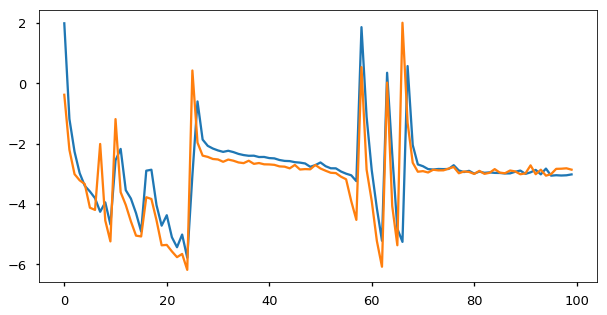

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [12]:
# Decoding Model

decoder = keras.Sequential()
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(1,1,OUTPUT_DIMENSION), return_sequences=True, stateful=True))
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, stateful=True))
decoder.add(MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
decoder.compile(loss=get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam(), metrics=[get_mixture_mse_accuracy(3,5)])
decoder.summary()

decoder.set_weights(model.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (1, 1, 64)                17408     
_________________________________________________________________
lstm_6 (LSTM)                (1, 64)                   33024     
_________________________________________________________________
mdn_3 (MDN)                  (1, 3)                    2275      
Total params: 52,707
Trainable params: 52,707
Non-trainable params: 0
_________________________________________________________________


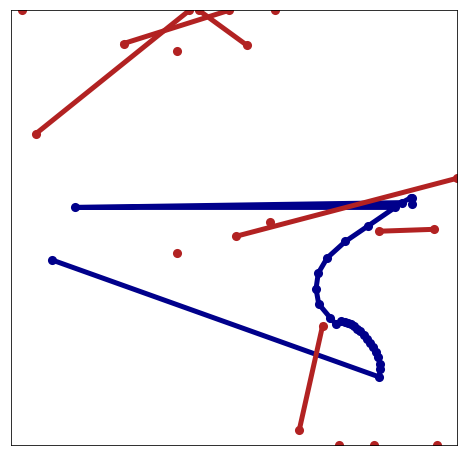

In [57]:
#plot_2D(perf_array_to_df(sequence_loader.examples[512]))
t = random.randint(0,len(sequence_loader.examples))

p = condition_and_generate(decoder,sequence_loader.examples[t], 5)
plot_double_2d(perf_array_to_df(sequence_loader.examples[t]), perf_array_to_df(p))
decoder.reset_states()
# plot_double_2d(in_df, out_df)